# Installations
----

In [3]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ba26dh2g
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ba26dh2g
  Resolved https://github.com/facebookresearch/detectron2.git to commit eddac5d5b4fce9b5eba5518f9ee348fa3a531407
  Preparing metadata (setup.py) ... done


# Imports
----

In [5]:
import os
import cv2
import pandas as pd
from IPython.display import Image

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog

from sklearn.preprocessing import MinMaxScaler

In [6]:
cfg = get_cfg()
best_model = "COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"
fast_model = "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(best_model)) # we can change the path here
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(best_model) # we can change the path here
predictor = DefaultPredictor(cfg)

[06/25 03:41:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x/139686956/model_final_5ad38f.pkl ...


model_final_5ad38f.pkl: 491MB [00:02, 177MB/s]                                


In [7]:
# TODO: add exploration of how keypoints work

In [66]:
# set up df
names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).keypoint_names
x_y_names = []
for n in names:
    x_y_names.append(n + '_pixel_x')
    x_y_names.append(n + '_pixel_y')
    x_y_names.append(n + '_scaled_x')
    x_y_names.append(n + '_scaled_y')
    x_y_names.append(n + '_score')
df = pd.DataFrame(columns=x_y_names + ["pose"])

In [67]:
df

,nose_pixel_x,nose_pixel_y,nose_scaled_x,nose_scaled_y,nose_score,left_eye_pixel_x,left_eye_pixel_y,left_eye_scaled_x,left_eye_scaled_y,left_eye_score,...,left_ankle_pixel_y,left_ankle_scaled_x,left_ankle_scaled_y,left_ankle_score,right_ankle_pixel_x,right_ankle_pixel_y,right_ankle_scaled_x,right_ankle_scaled_y,right_ankle_score,pose


In [68]:
# returns scaled keypoints in image - may help with classification - TBD
def keypoints_and_min_max_scale(keypoints):
    keypoints_x = keypoints[:, 0:1].cpu().detach().numpy()
    keypoints_y = keypoints[:, 1:2].cpu().detach().numpy()
    score_x_y = keypoints[:, 2:3].cpu().detach().numpy()

    pixel_keypoints = [[keypoints_x[i][0], keypoints_y[i][0], score_x_y[i][0]] for i in range(len(keypoints_x))]

    # scale the keypoints
    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(keypoints_x)
    scaled_y = scaler.fit_transform(keypoints_y)

    scaled_keypoints = [[scaled_x[i][0], scaled_y[i][0], score_x_y[i][0]] for i in range(len(scaled_x))]
    return {
        "pixel": pixel_keypoints,
        "scaled": scaled_keypoints
    }

In [69]:
def predict_keypoints_and_format(path_to_img_file):
    im = cv2.imread(path_to_img_file)
    outputs = predictor(im)
    if len(outputs["instances"]):
        # use the keypoints of only the main person in the photo
        keypoints = outputs["instances"][0].pred_keypoints[0, :, :3]
        # worth trying to store the tensor to a file?
        return keypoints_and_min_max_scale(keypoints)
        
    else:
        raise Exception("This file did not find any human to inference keypoints from. Try lowering the threshold")

In [70]:
keypoints_x_y = predict_keypoints_and_format("./dataset-for-classification/anjaneyasana/9554ccbb4b8a2f02e250d4d12c17dfadd2a039521ea8eebd70b64d890dc70808.png")
keypoints_x_y["pixel"]

[[122.93554, 105.491745, 9.436402],
 [128.40503, 100.74754, 1.8436049],
 [164.13902, 100.38261, 0.7715036],
 [144.81349, 105.12681, 1.8344208],
 [148.45981, 104.39693, 1.0424827],
 [151.7415, 143.81027, 0.6089584],
 [149.91833, 139.79594, 0.12675245],
 [171.7963, 79.94605, 0.765053],
 [153.92929, 85.78507, 0.24846077],
 [193.30962, 32.86901, 0.9037891],
 [164.50365, 44.54704, 0.6167983],
 [124.02944, 240.51892, 0.38263434],
 [107.25633, 236.13968, 0.3145026],
 [203.88396, 291.24536, 1.0246792],
 [39.434685, 266.42953, 0.78487587],
 [287.3848, 318.98068, 0.24358088],
 [36.517624, 348.9056, 0.5181183]]

In [71]:
# this will take ~10min to run
# build keypoints dataset
directory = "./dataset-for-classification/"
problem_files = []
for dir in os.listdir(directory):
    if not dir.startswith('.'):
        for file in os.listdir(directory + dir):
            try:
                full_file_location = f"{directory}{dir}/{file}"
                keypoints_x_y = predict_keypoints_and_format(full_file_location)
                for type in keypoints_x_y:
                    for index, name in enumerate(names):
                        column_name = f"{name}_{type}"
                        df.loc[full_file_location, column_name + '_x'] = keypoints_x_y[type][index][0]
                        df.loc[full_file_location, column_name + '_y'] = keypoints_x_y[type][index][1]
                        df.loc[full_file_location, name + '_score'] = keypoints_x_y[type][index][2]
                        df.loc[full_file_location, "pose"] = dir
            except Exception as e:
                print(f"There was an error with file: {full_file_location}. {e}")
                problem_files.append(f"{full_file_location}")

There was an error with file: ./dataset-for-classification/supta-matsyendrasana/7c9654114e5b38e88020605f52fb130b883472ad2ef37aace1a7d0e6c944bf63.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/eka-pada-rajakapotasana/5e220e3a63627a96c6a79427af948c21278e0269e5d818e508ec149cba799983.jpeg. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/salamba-sarvangasana/f1f525111a655d7ffeeb0862a3256852319f33b2e646bfef3fad54c6f8219747.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/salamba-sarvangasana/d1b1c4112838726a3bcadb9505a6aff76cbcbcf36d1fd7d58223f6a2edfd6c21.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-

libpng warning: iCCP: known incorrect sRGB profile


There was an error with file: ./dataset-for-classification/tadasana/a16d5c62a2cb24fa4bc884b868e67f17d63d6d487aa6f6942df5634f74178e36.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/tadasana/917c29fc921bca6c6d33d912eb34f539be652d6440a1d0b29ee3c8dd3e094479.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/tadasana/f8f462c7a4c6c7e965eeb853d8708f2d6d851c74f831505214d3bc24a0bd7117.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/tadasana/052910a2a5f55a1853491634e6858cd095d6f86edd60d508d2b3220c703bf54f.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/tadasana/75330ea223fa4f1429fbeda5

libpng warning: iCCP: known incorrect sRGB profile


There was an error with file: ./dataset-for-classification/adho-mukha-svanasana/baae829c26441337d25cda1bdfe59fb53119711b8c552999ec5c6532f6bdc7a4.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/adho-mukha-svanasana/31655841228f6eff89257ad73edaa50b887b9415c456584eeba94b38d6badaf2.png. This file did not find any human to inference keypoints from. Try lowering the threshold


libpng warning: cHRM: inconsistent chromaticities


There was an error with file: ./dataset-for-classification/adho-mukha-svanasana/51e53be3f0e7370cbfe678cdeeae06f52e6c5043ee0b97603261a7e428085b71.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/adho-mukha-svanasana/bded7893939a14d938b227ce40234946f4b780c63a3a059f3ac3a3c1ca4319de.png. This file did not find any human to inference keypoints from. Try lowering the threshold


libpng warning: iCCP: known incorrect sRGB profile


There was an error with file: ./dataset-for-classification/adho-mukha-svanasana/a08d056c537d5a4836eacd79464ab6dc3c0b89aa488c5ef9eef588ca92175d04.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/adho-mukha-vriksasana/bd44422091f7248dfa6cc9aee3fa6c28d4a3ad4b928f1ba785451f2f87709533.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/adho-mukha-vriksasana/0a6a3a9cf7e2c1d0d3c62777e750d10125e081623ff028f8d8893373b443172c.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/adho-mukha-vriksasana/bd97f70a8e79e392faf686665f4130e9fda63f53bbbc0d7fdfad71a793ab07bd.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-f

libpng warning: iCCP: known incorrect sRGB profile


There was an error with file: ./dataset-for-classification/baddha-konasana/319b2cf76f20a7e2b08a38471adc5294165d86e44e6459b33b7da8f01273b5a8.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/bharadvajasana-i/6f9101da72f0f2c6f425fc1df4bd4d79bb9b38af8c04a793cac0785b7d27f190.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/bharadvajasana-i/c7f33d357b68e01718685e4ba501915e42bb796f610be57092a5102c7852ba70.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classification/chaturanga-dandasana/e06f72ba30a57105f9c49844900ccff6b90f1511404beba7c82923de4201495f.png. This file did not find any human to inference keypoints from. Try lowering the threshold
There was an error with file: ./dataset-for-classificatio

In [72]:
for file in problem_files:
    print(file)

./dataset-for-classification/supta-matsyendrasana/7c9654114e5b38e88020605f52fb130b883472ad2ef37aace1a7d0e6c944bf63.png
./dataset-for-classification/eka-pada-rajakapotasana/5e220e3a63627a96c6a79427af948c21278e0269e5d818e508ec149cba799983.jpeg
./dataset-for-classification/salamba-sarvangasana/f1f525111a655d7ffeeb0862a3256852319f33b2e646bfef3fad54c6f8219747.png
./dataset-for-classification/salamba-sarvangasana/d1b1c4112838726a3bcadb9505a6aff76cbcbcf36d1fd7d58223f6a2edfd6c21.png
./dataset-for-classification/salamba-sarvangasana/07ef10b0866871974dcbbcf09404caa4399072fbe402a71b41eacf791349cb2b.png
./dataset-for-classification/salamba-sarvangasana/4f7003624c905bdbdb72a0c4af307a2cfa1a5780b06283131a39ba4c147768a2.png
./dataset-for-classification/virabhadrasana-i/f0002243c8be82708cebb5ed3d5a30c658f444bf803c2d67817dd39e9370e3f2.gif
./dataset-for-classification/bakasana/68b048cad384abcd34976d2b42f3f23c4e4a253a07762a1debd0cd2f407ee005.png
./dataset-for-classification/balasana/b375101425f8694823f8c6

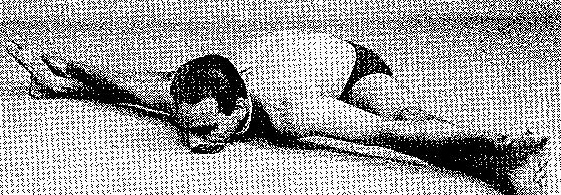

In [73]:
# let's view one to see what we're working with
Image(filename='./dataset-for-classification/upavistha-konasana/ed9c2c69582e897aa6d2f0b1ed229cca6e6a1130d7d136d2a994fc051dc0a884.png')

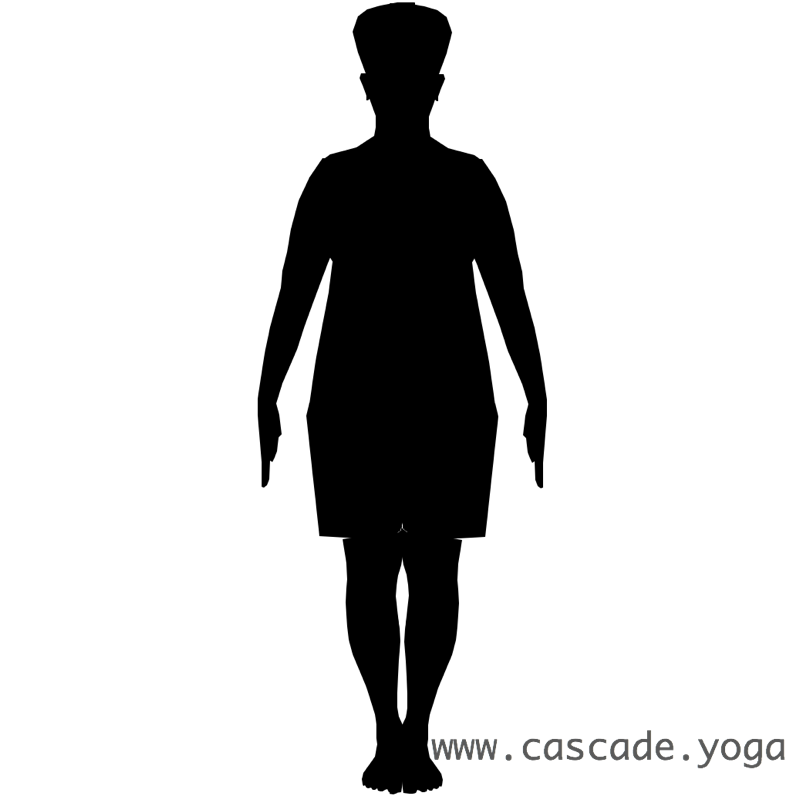

In [74]:
Image(filename='./dataset-for-classification/tadasana/f7671c7f49ed8db92ce44d96679e5f7f570630d4fc44d1d3f919259a9a542010.png')

Let's remove these files from our main dataset and compare image counts now that we have images we are not able to get keypoints from.

In [75]:
invalid_dir = "./dataset-no-keypoints"
os.mkdir(invalid_dir)
for file in problem_files:
    parts = file.split("/")
    pose = parts[2]
    filename = parts[3]
    target_dir = f"{invalid_dir}/{pose}"
    target_location = f"{target_dir}/{filename}"
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    os.rename(file, target_location)

In [76]:
# get image counts after moving images that cannot get keypoints out
img_counts = {}
parent_dir = "./dataset-for-classification/"
for dir in os.listdir(parent_dir):
    if not dir.startswith('.'):
        img_counts[dir] = len(os.listdir(parent_dir + dir))


for key in img_counts:
    if img_counts[key] < 50:
        print(f"Pose {key} now {img_counts[key]} images")

Pose sukhasana now 49 images
Pose tadasana now 48 images
Pose uttana-shishosana now 47 images
Pose vajrasana now 48 images
Pose virasana now 49 images


These are all so close to 50, that I am going to keep them. What I do need to do however, it remove the images from the dataframe since they will not be of service to us when it comes time to run our neural network on these instances.

In [77]:
df.head()

,nose_pixel_x,nose_pixel_y,nose_scaled_x,nose_scaled_y,nose_score,left_eye_pixel_x,left_eye_pixel_y,left_eye_scaled_x,left_eye_scaled_y,left_eye_score,...,left_ankle_pixel_y,left_ankle_scaled_x,left_ankle_scaled_y,left_ankle_score,right_ankle_pixel_x,right_ankle_pixel_y,right_ankle_scaled_x,right_ankle_scaled_y,right_ankle_score,pose
./dataset-for-classification/supta-matsyendrasana/46a4ab66d050f9f6570ffd40f061c51f7b04af3da891c1da1ad293df25f17f9a.png,202.190002,298.772827,0.069002,0.495455,1.031779,165.475555,285.506073,0.019108,0.469697,0.880347,...,57.630466,1.0,0.027273,0.228072,887.26593,57.630466,1.0,0.027273,0.343602,supta-matsyendrasana
./dataset-for-classification/supta-matsyendrasana/e80b428803dbf47d229a1fbe211970e1ba36c2a5466368b1ffd0ba24a562c013.png,526.920288,37.670383,0.977991,0.0,0.84754,537.23468,49.325935,1.0,0.05317,0.824227,...,177.537033,0.231579,0.638037,0.087119,68.601723,217.434891,0.0,0.820041,0.153936,supta-matsyendrasana
./dataset-for-classification/supta-matsyendrasana/4187f021d7e3b2d92ce2bdfabb90126e0a1f648a5e846b5cd452cafa12a3761c.png,719.845459,104.005745,0.950276,0.174129,2.304406,736.853394,120.369324,1.0,0.217247,2.173257,...,402.326447,0.828729,0.960199,0.227667,680.790161,417.431244,0.836096,1.0,0.325805,supta-matsyendrasana
./dataset-for-classification/supta-matsyendrasana/8fbb0fb028119ef65cbbb6aff56ed0b6835ac79a589657f43c1d8210c23b7df2.png,81.618423,80.691246,0.041439,0.25,0.403595,66.193481,80.285126,0.0,0.248077,0.923331,...,185.471191,1.0,0.746154,0.213619,433.144775,181.409958,0.985823,0.726923,0.097659,supta-matsyendrasana
./dataset-for-classification/supta-matsyendrasana/ba6c35d6e327e4da9a207357ee11e2dc9d56f2e5b45c7c8a9880c10879bbcf7a.png,94.697807,100.95269,0.034826,0.280088,1.96227,80.061249,100.367912,0.00995,0.277899,0.984184,...,206.212067,1.0,0.673961,0.449996,660.839722,206.212067,0.997015,0.673961,0.262296,supta-matsyendrasana


Okay, we're ready to run some modelling with this data!

In [78]:
df.to_csv("keypoints.csv")